# Aprendizaje automático 
# Proyecto 2: Housing prediction ML models
### Miguel Augusto March Piris

### Imports:

In [28]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# create output folder
if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('output/session1'):
    os.makedirs('output/session1')
    

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
## lets comare all of them 



### Algunas funciones no relevantes para el tema tratado: 

In [29]:
#Function to display score results from CV
def display_scores(scores,model_name = None):
    if(model_name):
        print("----",model_name,"----")
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

#Function to plat the values of a gridsearch with only one parameter changing. 
def plot_results(results,param_grid,variable_name,xlim = None,ylim = None):
    #plot the results
    plt.figure(figsize=(7, 7))
    plt.title("GridSearchCV",
              fontsize=16)

    values = param_grid[variable_name]
    
    plt.xlabel(variable_name)
    plt.ylabel("Score")

    ax = plt.gca()
    #ax.set_xlim(min_v, max_v)
    if xlim:
        min_v, max_v = xlim
        ax.set_xlim(min_v, max_v)
    if ylim:
        min_v, max_v = ylim
        ax.set_ylim(min_v, max_v)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_'+variable_name].data, dtype=float)


    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = (-results['mean_%s_score' % (sample)])
        sample_score_std = (results['std_%s_score' % (sample)])
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0)
        ax.plot(X_axis, sample_score_mean, style,
                alpha=1 if sample == 'test' else 0.7,
                label="(%s)" % ( sample))

    best_index = np.nonzero(results['rank_test_score' ] == 1)[0][0]
    best_score =  (-results['mean_test_score' ][best_index])

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [best_score, best_score],
            linestyle='-.',  marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()


def create_att_dic(list_att):
    dic_att={}
    for key in initial_atr.keys():
        dic_att[key]=[]
    for (k,v) in list_att:
        dic_att[k].append(v)
    return dic_att

In [31]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [32]:
#Loading datasets
housing = pd.read_csv('dataset/housing-snapshot/train_set.csv',index_col=0) 
test_housing = pd.read_csv('dataset/housing-snapshot/test_set.csv',index_col=0)
#Postcode is in reality a categorical feature
housing['Postcode'] = pd.Categorical(housing.Postcode)

## divide using the scikit learn function
housing["price_cat"] = pd.cut(housing["Price"],
                               bins=[0., 500000, 1000000, 1500000, 2000000., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["price_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
def price_cat_proportions(data):
    return data["price_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": price_cat_proportions(housing),
    "Stratified": price_cat_proportions(strat_test_set),
    "Random": price_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

for set_ in (strat_train_set, strat_test_set):
    set_.drop("price_cat", axis=1, inplace=True)

## Para cuando quiero el dataset nuevo

In [5]:
X_train = strat_train_set.drop("Price", axis=1).copy()
y_train = strat_train_set["Price"].copy()
housing = strat_train_set.drop("Price", axis=1).copy()
housing_labels = strat_train_set["Price"].copy()

## Pipe del proyecto base:

In [6]:
housing_num = housing.select_dtypes(include=[np.number]).columns
housing_cat = housing.select_dtypes(include=[np.object]).columns

In [7]:
## create a function to replace 0 by NaN
def replace_0_2_NaN(data):
    data[data == 0] = np.nan
    return data


# column index
Rooms_ix, Bedroom2_ix, Bathroom_ix, BuildingArea_ix = 0, 2, 3, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        rooms_per_building_area = X[:, Rooms_ix] / (1.0 +X[:, BuildingArea_ix])# add 1 to avoid 0 division
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, Bedroom2_ix] / (1.0 + X[:, Bathroom_ix]) # add 1 to avoid 0 division
            return np.c_[X, rooms_per_building_area, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_building_area]
#Para las columnas con muchos ceros sin sentido. A las que además se les aplicará la función logaritmo
num0_pipeline = Pipeline([
        ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
        ('imputer', SimpleImputer(strategy="median")),
        ('log',FunctionTransformer(np.log1p, validate=True)),
        ('std_scaler', StandardScaler()),
    ])
#Para las otras columnas numéricas
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
#Para las variables categóricas. Principalmente utilizaremos el OneHotEncoder
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])
"""
Columnas numéricas:  ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 
'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

Columnas categóricas:  ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
"""

#Estas son las columnas seleccionadas en el proyecto base para cada pipeline.
num_attribs0 = ['Landsize','BuildingArea']
num_attribs1 = list(housing_num)
cat_attribs = ["CouncilArea",'Type','Suburb','Postcode']

#Creamos la "full_pipeline", es decir la pipeline que engloba a todas las otras.
full_pipeline = ColumnTransformer([
        ("num0", num0_pipeline, num_attribs0),
        ("num1", num_pipeline, num_attribs1),
        ("cat", cat_pipeline, cat_attribs),
])
#Preprocesamos los datos utilizando la "full_pipeline"
housing_prepared = full_pipeline.fit_transform(housing,housing_labels)
housing_prepared

<4345x517 sparse matrix of type '<class 'numpy.float64'>'
	with 82555 stored elements in Compressed Sparse Row format>

## Diferentes modelos de base

En la celda siguiente se ejecutan los 5 modelos distintos que podíamos utilizar para este proyecto. Aunque los resultados no son definitivos porque entran muchas variables distintas a la hora de discernir que modelo es el el mejor, podemos hacernos una primera idea de cuales son las posibilidades de cada modelo.

Para ello hacemos uso de los modelos sin tocar mucho los diferentes hiperparámetros y utilizamos para tener más consistencia en los resultados de esta prueba la función 

El código está comentado para evitar que el notebook se quede mucho tiempo atascado ejecutando esta celda.

In [8]:
"""
forest_reg = RandomForestRegressor(n_estimators=20, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

n_neighbors = 3
knn_reg = neighbors.KNeighborsRegressor(n_neighbors)
knn_reg.fit(housing_prepared, housing_labels)


svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

models = [(lin_reg,"lin_reg"),
          (tree_reg,"Decision Tree"),
          (knn_reg,"KNN-Regressor"),
          (forest_reg,'Random Forest'),
          (svm_reg,'SVM Regressor')
]
for model in models:
    scores = cross_val_score(model[0], housing_prepared, housing_labels, scoring="neg_root_mean_squared_error", cv=10,n_jobs=-1)
    print(-scores.mean())
    display_scores(-scores, model[1])
"""

'\nforest_reg = RandomForestRegressor(n_estimators=20, random_state=42)\nforest_reg.fit(housing_prepared, housing_labels)\n\nlin_reg = LinearRegression()\nlin_reg.fit(housing_prepared, housing_labels)\n\ntree_reg = DecisionTreeRegressor(random_state=42)\ntree_reg.fit(housing_prepared, housing_labels)\n\nn_neighbors = 3\nknn_reg = neighbors.KNeighborsRegressor(n_neighbors)\nknn_reg.fit(housing_prepared, housing_labels)\n\n\nsvm_reg = SVR(kernel="linear")\nsvm_reg.fit(housing_prepared, housing_labels)\n\nmodels = [(lin_reg,"lin_reg"),\n          (tree_reg,"Decision Tree"),\n          (knn_reg,"KNN-Regressor"),\n          (forest_reg,\'Random Forest\'),\n          (svm_reg,\'SVM Regressor\')\n]\nfor model in models:\n    scores = cross_val_score(model[0], housing_prepared, housing_labels, scoring="neg_root_mean_squared_error", cv=10,n_jobs=-1)\n    print(-scores.mean())\n    display_scores(-scores, model[1])\n'

#### Resultados:

- Linear Regressor:

    - Mean: 380655.96847603103
    - Standard deviation: 49217.88546072668

- Decision Tree:

    - Mean: 421726.4131430878
    - Standard deviation: 49564.46361021512

- K-Nearest Neigbours (KNN) Regressor:

    - Mean: 369372.76227516925
    - Standard deviation: 49121.12777363014

- Random Forest:

    - Mean: 308652.50854966586
    - Standard deviation: 44595.78784796293

- Support Vector Machine (SVM) Regressor:

    - Mean: 660668.7269286377
    - Standard deviation: 54076.75231812296

#### Reflexión:

Comparando los resultados podemos intuir que ni el modelo SVM ni el Decision Tree tienen muy buenas oportunidades con el problema que estamos tratando. 

Por otro lado el Random Forest, que podríamos decir que es una versión más complicada del modelo Decision Tree, si que tiene buenos pronósticos. Además le siguen de cerca el KNN y el Lineal Regressor.

También podría ser que la pipeline utilizada para el preproceso de datos estuviera beneficiando mucho a los modelos que salen mejor parados o viceversa. Es por ello que más adelante probaremos un sistema de Feature Selection para ver como se comportan los modelos cuando las pipelines se adaptan a ellos.

## Mi pipeline:

### Invert variable:

Es una función que por cada columa de entrada, habrá dos columnas de salida. La primera será igual y la segunda será 1/columna.
Utilizando esta función junto a la función _PolynomialFeatures(interaction_only=True,degree=2))_ conseguimos unas interacciones que podrían resultar interesantes. Ya no solo col1 * col2, sino también col1/col2, col2/col1 y 1/(col1 * col2).

### Categorical to Mean:

Es una función que nos convertirá las columnas categóricas en valores numéricos. Para ser concretos calculará la media del precio para cada uno de los valores.

Por ejemplo: Para la columna type, se calcularía la media del precio de todas las filas que tienen el valor **_t_** y se sustituiría por todas las **_t_**'s. Así con todos los valores únicos de la columna Type.

### Clean Outlayers:

Es una función que limpia los Outlayers basándose en los quantiles.

### Problemas:

Un problema que he detectado con mi pipeline es que si vamos a utilizar una función para hacer un CV tenemos un problema importante. Esto es así porque en _Categorical_2_mean()_ calculamos la media del precio asociado a cada valor de las columnas categóricas, de manera que cada fila contiene (potencialmente) información relevante de otras muchas filas. Dado que el preproceso de datos se hace antes de enviar los datos a la función CV tenemos un problema muy grande porque dentro de CV los datos ya están mezclados y da igual que haga la division entre train y test, porque el train ya va a tener información que se puede extraer del test.

Para hacer esto correctamente tendría que haber hecho mi propia función CV o encontrar alguna que me permitiera pasarle la pipeline. Dado que me di cuenta después de entregar el proyecto y que al final no utilicé la pipeline con esa función no lo he programado.

Me di cuenta de este problema al estar haciendo unas pruebas y encontrarme que la media de los scores estaba por debajo de 50.000, cosa que no tenía ningún sentido comparándolo con los resultados anteriores.


Otro problema que he encontrado es que la función CleanOutlayers no funciona demasiado bien con el Random Forest Regressor. He leído en internet que la forma que tiene de aislar los Outlayers el Random Forest en sus ramas es suficientemente robusta como para no tener que limpiarlos de esta manera. Quizá por ello los resultados empeoraban al utilizar esta función.

In [9]:
class invert_variable(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
        #self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        data=np.zeros(X.shape,dtype=np.float)
        for i in range(X.shape[1]):
            data[:, 0]=1/X[:, 0]
        return np.c_[X,data]
class Categorical_2_mean(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.medias_por_columnas=[]
        self.media_y=0
        #self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        self.media_y = y.mean()
        self.medias_por_columnas=[]
        #Para cada columna
        for i in range(X.shape[1]):
            medias = {}
            columna = X[:,i]
            unicos = np.unique(columna)
            #Para cada valor guardo la media
            for u in unicos:
                medias[u]=y[columna==u].mean()
                
            self.medias_por_columnas.append(medias)
            
        return self  # nothing else to do
    
    def transform(self, X):
        data = np.ones((X.shape[0]))
        
        for i in range(X.shape[1]):
            columna = X[:,i]
            media = self.medias_por_columnas[i]
            nueva_columna = np.zeros(X.shape[0])+self.media_y
            
            #Para cada valor distinto dentro de la categoría
            for k in media.keys():
                nueva_columna[columna == k] = media[k]
            
            #Si es la primera vez
            if i == 0:
                data = nueva_columna
            else:
                data = np.c_[data,nueva_columna]
        return data

class Clean_Outlayers_Quantile(BaseEstimator, TransformerMixin):
    def __init__(self,q=0.01): # no *args or **kargs
        self.q=q
        self.low_q_col=[]
        self.high_q_col=[]
        #self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        #Para cada columna
        for i in range(X.shape[1]):
            columna = X[:,i]
            self.high_q_col.append(np.quantile(a=columna , q=1-self.q))
            self.low_q_col.append(np.quantile(a=columna ,q=self.q))
        return self  # nothing else to do
    
    def transform(self, X):
        for i in range(X.shape[1]):
            q_high=self.high_q_col[i]
            q_low =self.low_q_col[i]
            columna = X[:,i]
            columna[columna>q_high]=q_high
            columna[columna<q_low]=q_low
        return X

# Primero el preprocesamiento
rf_pipe_num0 = Pipeline([
    ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
    ("fill_nan",SimpleImputer(strategy="mean")),
    ("clean_outlayer",Clean_Outlayers_Quantile()),
    ('log',FunctionTransformer(np.log1p, validate=True)),
    ("std",StandardScaler()),
])

rf_pipe_num1 = Pipeline([
    ("fill_nan",SimpleImputer(strategy="mean")),
    ("clean_outlayer",Clean_Outlayers_Quantile()),
    ("std",StandardScaler()),
])

rf_pipe_poli = Pipeline([
    ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
    ("fill_nan",SimpleImputer(strategy="mean")),
    ('zeros2NaN_2',FunctionTransformer(func = replace_0_2_NaN,validate=False)),# por si acaso hay algun 0
    ("invert_1/var",invert_variable()),
    ("poly_interact_2",PolynomialFeatures(interaction_only=True,degree=2)),
    ("std",StandardScaler()),
])

rf_cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
])

# 
rf_cat2mean_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('cat2mean', Categorical_2_mean()),
        ('zeros2NaN',FunctionTransformer(func = replace_0_2_NaN,validate=False)),
        ("std",StandardScaler()),
])
"""
NUMERICAL:    ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
CATEGORICAL:  ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
"""
num_attribs0 = ['Landsize','BuildingArea']
num_attribs1 = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

num_attribs_poli = ['Rooms','BuildingArea']

cat_attribs =['Type',"CouncilArea",'Suburb','Regionname','Postcode']

rf_full_pipe = ColumnTransformer([
    ("num0", rf_pipe_num0, num_attribs0),
    ("num1", rf_pipe_num1, num_attribs1),
    ("poli", rf_pipe_poli, num_attribs_poli),
    ("cat",  rf_cat_pipe, cat_attribs),
    ("cat_2_mean",  rf_cat2mean_pipe, cat_attribs)
])

X_train_prepared = rf_full_pipe.fit_transform(X_train,y_train)

X_test_prepared = rf_full_pipe.transform(test_housing)
print("Prepared: ",X_train_prepared.shape)

Prepared:  (4345, 537)


## Backward Feature Selection:

### Explicación:
Vamos a utilizar un sistema de selección de características para ver como pueden mejorar los modelos si adaptamos las features con las que trabajan. 

En esta explicación yo llamo atributos a las columnas de entrada a la pipeline.

En cada iteración el número total de atributos se mantiene.
Para ser concretos vamos a ir quitando en una misma iteración de uno en uno todos los atributos y calculando con que atributos de entrada el modelo se comporta mejor. 

El resultado de la combinación que se comporte mejor será comparado con el resutado mejor de la iteración anterior, y si es mejor seguiremos con la siguiente iteración, pero quitando el atributo correpondiente de la lista de atributos. En caso contrario habremos acabado y tendremos el resultado final. 
En caso de que una de las sublistas de atributos se quede vacía esto significa que la pipeline a la que está asociada no funciona nada bien con el modelo que estamos probando.

### Uso:

Todo este proceso podremos repetirlo con distintas pipelines y con distintos modelos para intentar encontrar los atributos y modelos que consiguen mejores resultados sin tener que calcular todas las posibles combinaciones, que sería de una complejidad enorme.

En mi caso lo he utilizado para asegurarme de que ningún modelo estaba funcionando especialmente mal por culpa de los atributos y de la pipeline y además, para refinar un poco más los modelos que mejores resultados daban en el GridSearch CV.

In [10]:
"""
Aquí tenemos todos los posibles atributos:
NUMERICAL:    ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
CATEGORICAL:  ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
"""
# Aquí van los distintos atributos que entrarán a las pipelines en un principio.
# No tienen porqué estar todos los numéricos ni todos los categóricos en cada lista.

num_log_att = ['Landsize','BuildingArea']

num_att = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

num_poli_att = ['Rooms','BuildingArea','Bathroom']

cat_att =['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']

initial_atr = {
    "num_log_att":num_log_att.copy() ,
    "num_att":num_att.copy() ,
    "num_poli_att":num_poli_att.copy() ,
    "cat_att":cat_att.copy() ,
}

initial_full_pipe = ColumnTransformer([
            ("num0", rf_pipe_num0, initial_atr["num_log_att"]),
            ("num1", rf_pipe_num1, initial_atr["num_att"]),
            ("poli", rf_pipe_poli, initial_atr["num_poli_att"]),
            ("cat",  rf_cat_pipe, initial_atr["cat_att"])
])

# Modelo: Este será el modelo con el que se calcule el la feature selection.
# Deberíamos probarlos todos para ver si consiguen una mejora notable con un preprocesamiento de datos más adaptado.
# Aquí muchos de los modelos están con parámetros bastante "baratos" para que se ejecute todo más rápido,
# aún así se pueden tocar todos los parámetros de los diferentes modelos, pero esto implica tiempos muy largos de cálculo.


model = RandomForestRegressor(max_depth=10,n_estimators = 20  , random_state=42)
#model = LinearRegression()

#En caso de utilizar el KNN no podemos tener en cuenta la pipeline de categorías con OneHotEncoder, 
#pues sube demasiado la dimensionalidad. Por ello ponemos la lista vacía.
#model = neighbors.KNeighborsRegressor(3)
#cat_att =[]

start = time.time()

# Calculamos primero con todos los atributos.
X_train_initial = initial_full_pipe.fit_transform(X_train,y_train)

previous_score_winner = -cross_val_score(model, X_train_initial, y_train,scoring="neg_root_mean_squared_error", cv=5,n_jobs=-1).mean()
# Creamos una lista de tuplas (nombre_pipeline, nombre_columna) para un manejo más sencillo en el bucle.
# Cada tupla representa un atributo de entrada a la pipeline.
actual_list_atts = []    
for k in initial_atr.keys():
    for v in initial_atr[k]:
        actual_list_atts.append((k,v))

buscando = True
cont=0
print(model)
while buscando and len(actual_list_atts)!=0:
    
    end = time.time()
    tiempo=end - start
    start = end
    if cont == 0:
        print("El primer tiempo (T1) solo se calcula con 1 CV, mientras que el resto tardarán aproximadamente T1 x N_atributos")
    dic_=create_att_dic(actual_list_atts)
    print(cont,". Score: ",previous_score_winner)
    print()
    print("Tiempo(seg) cálculo:" ,tiempo )
    print()
    print(len(actual_list_atts)," atributos: ")
    for k in dic_.keys():
        print("  -",k,dic_[k])
    print("-------------------------------------------------------------------------------------------")

    scores_ronda=[]
    for at in actual_list_atts:
        actual_list_without_at = actual_list_atts.copy()
        actual_list_without_at.remove(at)
        #Aqui hemos quitado la feature
        dict_att=create_att_dic(actual_list_without_at)
        #Creamos la nueva pipe sin dicho atributo
        actual_full_pipe = ColumnTransformer([
            ("num0", rf_pipe_num0, dict_att["num_log_att"]),
            ("num1", rf_pipe_num1, dict_att["num_att"]),
            ("poli", rf_pipe_poli, dict_att["num_poli_att"]),
            ("cat",  rf_cat_pipe, dict_att["cat_att"])
        ])
        #Procesamos los datos con la nueva pipe
        X_train_actual = actual_full_pipe.fit_transform(X_train,y_train)
        #Calculamos con el modelo y guardamos como de bueno es
        actual_score = - cross_val_score(model, X_train_actual, y_train,
                                         scoring="neg_root_mean_squared_error", cv=5,n_jobs=-1).mean()
        scores_ronda.append((actual_score,at))
    
    winner = min(scores_ronda, key= lambda x : x[0])
    #Aquí tenemos el mejor score y el atributo que hay que quitar para tenerlo
    score_winner, att_winner = winner
    
    #Si este resultado es mejor que el mejor de la ronda anterior
    if score_winner < previous_score_winner:
        actual_list_atts.remove(att_winner)
        previous_score_winner = score_winner
        
    #Si no es mejor hemos acabado
    else:
        buscando=False
    cont+=1
    
final_att = create_att_dic(actual_list_atts)
print("MEJOR SOLUCIÓN: ")
print(final_att)
print("Score: ",previous_score_winner)

DecisionTreeRegressor(max_depth=4)
El primer tiempo (T1) solo se calcula con 1 CV, mientras que el resto tardarán aproximadamente T1 x N_atributos
0 . Score:  413762.84402127645

Tiempo(seg) cálculo: 2.5505595207214355

24  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
1 . Score:  413627.2176858267

Tiempo(seg) cálculo: 4.578698635101318

23  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
  - num_poli_att ['Rooms', 'BuildingArea

#### Ejemplo de la salida de la celda anterior en caso de no tener tiempo de ejecutarla:

RandomForestRegressor(max_depth=10, n_estimators=20, random_state=42)
El primer tiempo (T1) solo se calcula con 1 CV, mientras que el resto tardarán aproximadamente T1 x N_atributos
0 . Score:  320939.4529929297

Tiempo(seg) cálculo: 6.4403440952301025

24  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
1 . Score:  320803.46586287156

Tiempo(seg) cálculo: 87.13541197776794

23  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
2 . Score:  320055.736743595

Tiempo(seg) cálculo: 80.07244563102722

22  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
3 . Score:  317347.9045733091

Tiempo(seg) cálculo: 54.85602951049805

21  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
4 . Score:  315566.2465887208

Tiempo(seg) cálculo: 50.84276008605957

20  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
5 . Score:  315009.63095124095

Tiempo(seg) cálculo: 45.56109118461609

19  atributos: 
  - num_log_att ['Landsize', 'BuildingArea']
  - num_att ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude']
  - num_poli_att ['Rooms', 'BuildingArea', 'Bathroom']
  - cat_att ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']
-------------------------------------------------------------------------------------------
MEJOR SOLUCIÓN: 

{

        'num_log_att': ['Landsize', 'BuildingArea'], 

        'num_att': ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude'], 

        'num_poli_att': ['Rooms', 'BuildingArea', 'Bathroom'], 

        'cat_att': ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']

}

Score:  315009.63095124095

### Conclusiones feature selection:

Utilizando este método con los distintos modelos podemos ver claramente que el Random Forest tiene las de ganar en este problema. Además, una vez encontremos unos buenos parámetros con ese modelo podremos volver a ejecutar esta celda con dichos parámetros y ver si conseguimos así un modelo aún mejor.

## Cross-Validation Grid-Search:

### Explicación:

El Grid-Search es un método que nos permite hacer una búsqueda de los mejores parámetros para un modelo. Ejecutará una CV con cada combinación de parámetros de manera que tenemos una seguridad un mayor del resultado de esos parámetros.

### Pipeline definitiva:

La pipeline escogida es la pipeline base del proyecto con la diferencia de que he modificado los atributos que entran a dicha pipeline. Esto es así porque al probar distintas pipelines esta ha sido la que ha resultado el mejor score con diferencia.

In [11]:
# Esta lista servirá para llevar la cuenta de los últimos mejores resultados.
lista_resultados=[]

In [12]:
# Estas son las columnas seleccionadas por mi para cada pipeline.
# Dado que la pipeline del proyecto base daba mejores resultados me he quedado con ella.
num_attribs0 = ['Landsize','BuildingArea']
num_attribs1 = ['Distance', 'Bedroom2', 'Bathroom', 'Car', 
'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
cat_attribs = ["CouncilArea",'Type','Suburb','Postcode']

# Creamos la "full_pipeline", es decir la pipeline que engloba a todas las otras.
full_pipeline = ColumnTransformer([
        ("num0", num0_pipeline, num_attribs0),
        ("num1", num_pipeline, num_attribs1),
        ("cat", cat_pipeline, cat_attribs),
])

In [13]:
X_train_prepared = full_pipeline.fit_transform(X_train,y_train)
# Como los mejores resultados en la feature selection los ha tenido el Random Forest vamos a hacer le grid-search con él.
model = RandomForestRegressor(random_state=42)

print(X_train_prepared.shape)

(4345, 516)


Aquí he probado valores y rangos muy distintos. He intentado evitar hacer GridSearch's con varios parámetros con muchos valores, pues las combinaciones totales aumentan con un productorio de las combinaciones en un solo parámetro.

Finalmente, aunque ha sido útil para quedarme con las mejores soluciones, no ha sido solo el valor que retornaba el CV GridSearch lo que he utilizado para decidir que solución era la mejor entre todas las otras, sino que también me he dejado guiar por el resultado del Kaggle.

In [20]:
#Aquí podemos poner distintos valores de los parámetros de nuesto modelo.
#Como estamos utilizando el Random Forest Regressor los valores que hay aquí corresponden a sus parámetros.
rf_param_grid = {
                'max_features': [1,2,3],#range(8,168,20),
                'n_estimators': [10,20,30],#[82],
                    #'max_depth': [None],
                   #'bootstrap': [False],
                #"min_samples_split":[2,3],
                #"min_samples_leaf":[1,2],
}
rf_grid_search = GridSearchCV(model, param_grid=rf_param_grid, cv=5,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True,n_jobs=-1)
rf_grid_search.fit(X_train_prepared, y_train)

print("Best trained model:")
print(rf_grid_search.best_estimator_)
print("Best parameters:")
print(rf_grid_search.best_params_)
print("Best Score")
print(np.sqrt(-rf_grid_search.best_score_),-rf_grid_search.best_score_)
lista_resultados.append(("SCORE: ",-rf_grid_search.best_score_,rf_grid_search.best_params_,))

Best trained model:
RandomForestRegressor(bootstrap=False, max_features=2, n_estimators=30,
                      random_state=42)
Best parameters:
{'max_features': 2, 'n_estimators': 30}
Best Score
568.4585596580898 323145.13404855004


In [22]:
#rf_grid_search.cv_results_

In [23]:
lista_resultados.sort(key=lambda x : x[1] )
lista_resultados

[('SCORE: ',
  299701.3608987021,
  {'bootstrap': False,
   'max_depth': None,
   'max_features': 108,
   'n_estimators': 82}),
 ('SCORE: ', 323145.13404855004, {'max_features': 2, 'n_estimators': 30})]

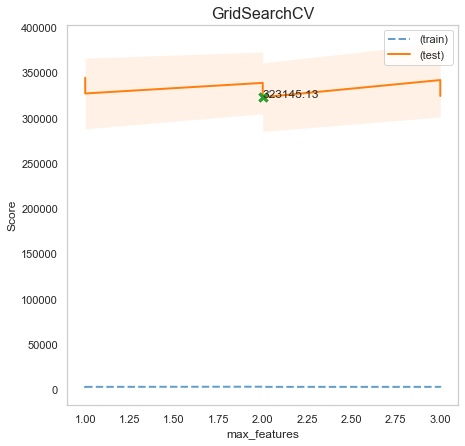

In [25]:
# Con esta función podemos hacer una visualización de los resultados respecto a un solo parámetro cambiante.
plot_results(rf_grid_search.cv_results_,rf_param_grid,"max_features")#,ylim=(280000,320000))

### Calcular la solución y guardarla en un fichero _.csv_ :

In [17]:
X_test = test_housing
X_test_prepared = full_pipeline.transform(test_housing)

# El modelo solución: 
model=RandomForestRegressor(max_features=128,n_estimators=82,max_depth=None,bootstrap=False,random_state=42)
model.fit(X_train_prepared, y_train)

y_pred = model.predict(X_test_prepared)

df_output = pd.DataFrame(y_pred)
df_output = df_output.reset_index()
df_output.columns = ['index','Price']

df_output.to_csv('output/prediciones.csv',index=False)

## Conclusiones finales:

Creo que todos los modelos que hemos visto son potentes y tienen su utilidad, sino no seguirían existiendo.
En este caso el Random Forest es el que mejores resultados ha conseguido al principio. Aunque este parecía prometedor hemos tenido que hacer algunas comprobaciones para no caer en la trampa de escoger el primero que daba un buen resultado. 

Después de comprobar si podría ser culpa del preprocesamiento de los datos nos ha quedado un poco más claro que el Random Forest seguía manteniendo una buena ventaja frente a sus competidores:

*     El SVM ha sido descartado por sus pésimos resultados.

*     El Decision Tree ha sido descartado porque el Random Forest es una versión más refinada y robusta del Decisión Tree y además estaba dando mejores resultados.

*     El Linear Regressor no tenía malos resultados pero no se podía trabajar demasiado más con él, pues ya lo había intentado con el Feature Selection y no había conseguido superar al Random Forest.

*     El KNN Regressor, aunque tenía una puntuación similar al Linear Regressor aún se podría modificar cambiando el parámetro n_neighbours. Haciendo unas pruebas con el GridSearchCV encontré que el resultado mejoraba, pero no lo suficiente como para alcanzar al Random Forest.
 
*     Dado que al final solo nos interesa el mejor modelo, la única opción viable era refinar el Random Forest al máximo y jugar con el GridSearchCV y con la Feature Selection hasta conseguir el mejor resultado posible.